In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm

import os
import argparse
import numpy as np
from copy import deepcopy

from models import *
from models.resnet import *
from utils.datasets import * 
from utils.utils import * 
import test

from terminaltables import AsciiTable

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--model-name', type=str, default='VGG16', help='model name')
    parser.add_argument('--checkpoint', '-ckpt', type=str, default='VGG16/checkpoint/last.pth', help='checkpoint path')
    parser.add_argument('--saved-dir', type=str, default='VGG16/sensitivity', help='sensitivity saved directory')
    parser.add_argument('--layer-keep', type=float, default=0.01, help='channel keep percent per layer')
    parser.add_argument('--img-size', type=int, default=32, help='inference size (pixels)')

    opt = parser.parse_args(args=[])
#     opt = parser.parse_args()

    opt.model_name = 'VGG16'
    opt.checkpoint = 'exp_VGG16/sp/checkpoint/last.pth'
    opt.saved_dir = 'exp_VGG16/sensitivity'
    
    print(opt)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # get original model
    checkpoint = opt.checkpoint
    model_name = opt.model_name
    assert os.path.isfile(checkpoint), 'Error: no %s file found!'%checkpoint
    if checkpoint.endswith('.pth'): # only load weights from file
        model = globals()[opt.model_name]()
        model.load_state_dict(torch.load(checkpoint)['model'])
    else: # load network architecture and weights from file 
        model = torch.load(checkpoint)

    model = model.to(device)
    
    # test dataset
    batch_size = 128
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
    testloader = cifar10_test_dataset(batch_size=batch_size, nw=nw)
    
    eval_model = lambda model:test.test(model=model, testloader=testloader)
    obtain_num_parameters = lambda model:sum([param.nelement() for param in model.parameters()])

    print("\nlet's test the original model:")
    origin_model_metric = eval_model(model)
    origin_nparameters = obtain_num_parameters(model)
    

Namespace(checkpoint='exp_VGG16/sp/checkpoint/last.pth', img_size=32, layer_keep=0.01, model_name='VGG16', saved_dir='exp_VGG16/sensitivity')
Files already downloaded and verified

let's test the original model:

 test_loss   correct     total       Acc


     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 71.77it/s]


In [14]:
    # sensitivity ['module_idx', 'percent', 'real_percent', 'Acc', 'loss', 'mask']
    sen = []
    
    percent_list = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, \
                    0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
    
    masked_model = deepcopy(model)
    
    origin_module_list = model.get_module_list()
    masked_module_list = masked_model.get_module_list()

    for m_idx,(m,origin_m) in enumerate(zip(masked_module_list,origin_module_list)):
        for percent in percent_list:
            num_filter = m['bn'].weight.data.shape[0]
            bn = m['bn'].weight.data.abs().clone()
            
            y,i = torch.sort(bn)
            thre_index = int(num_filter * percent)
            thre = y[thre_index]
            
            # 当前卷积模块最少要保留的输出通道数目
            min_channel_num = int(num_filter * opt.layer_keep) if int(num_filter * opt.layer_keep) > 0 else 1
            
            mask = m['bn'].weight.data.abs().ge(thre)
            
            if int(torch.sum(mask)) < min_channel_num: # 当剪枝后输出通道数目小于当前卷积模块最少要保留的输出通道数目
                _, sorted_index_weights = torch.sort(weight_copy,descending=True)
                mask[sorted_index_weights[:min_channel_num]]=1. 
            
            m['bn'].weight.data.mul_(mask)
            m['bn'].bias.data.mul_(mask)
            
            remain = int(torch.sum(mask))
            pruned = num_filter - remain
            real_percent = pruned/num_filter
            
            print('\nmodule_idx:%3g, percent:%3g'%(m_idx, percent))
            metric = eval_model(masked_model)
            Acc = 100.*metric[1]/metric[2]
            loss = metric[0]
            
            sen.append([m_idx, percent, real_percent, Acc, loss, mask])
            
        m['bn'].weight.data.copy_(origin_m['bn'].weight.data)
        m['bn'].bias.data.copy_(origin_m['bn'].bias.data)
    
    log = ('%10s'*5)%('module_idx', 'percent', 'real', 'Acc', 'loss')
    print(log)
    
    for s in sen:
        m_idx = s[0]
        percent = s[1]
        real = s[2]
        Acc = s[3]
        loss = s[4]
        
        log = ('%10.5g'*5)%(m_idx, percent, real, Acc, loss)
        
        print(log)
        



module_idx:  0, percent:0.05

 test_loss   correct     total       Acc


     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 71.82it/s]



module_idx:  0, percent:0.1

 test_loss   correct     total       Acc


     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 75.05it/s]


module_idx:  0, percent:0.15

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 76.38it/s]



module_idx:  0, percent:0.2

 test_loss   correct     total       Acc


     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 73.68it/s]


module_idx:  0, percent:0.25

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 72.53it/s]


module_idx:  0, percent:0.3

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 72.35it/s]


module_idx:  0, percent:0.35

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 75.45it/s]


module_idx:  0, percent:0.4

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 72.83it/s]



module_idx:  0, percent:0.45

 test_loss   correct     total       Acc


     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 76.01it/s]



module_idx:  0, percent:0.5

 test_loss   correct     total       Acc


     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 72.91it/s]


module_idx:  0, percent:0.55

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 72.77it/s]


module_idx:  0, percent:0.6

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 75.09it/s]



module_idx:  0, percent:0.65

 test_loss   correct     total       Acc


     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 76.63it/s]


module_idx:  0, percent:0.7

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 75.38it/s]



module_idx:  0, percent:0.75

 test_loss   correct     total       Acc


     0.311  9.30e+03     1e+04        93: 100%|██████████| 79/79 [00:01<00:00, 73.96it/s]



module_idx:  0, percent:0.8

 test_loss   correct     total       Acc


     0.413  9.07e+03     1e+04      90.7: 100%|██████████| 79/79 [00:01<00:00, 76.58it/s]


module_idx:  0, percent:0.85

 test_loss   correct     total       Acc



     0.562   8.8e+03     1e+04        88: 100%|██████████| 79/79 [00:01<00:00, 76.72it/s]


module_idx:  0, percent:0.9

 test_loss   correct     total       Acc



     0.965  7.82e+03     1e+04      78.2: 100%|██████████| 79/79 [00:01<00:00, 75.12it/s]


module_idx:  0, percent:0.95

 test_loss   correct     total       Acc



      3.84  3.52e+03     1e+04      35.2: 100%|██████████| 79/79 [00:01<00:00, 72.09it/s]



module_idx:  1, percent:0.05

 test_loss   correct     total       Acc


     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 77.58it/s]



module_idx:  1, percent:0.1

 test_loss   correct     total       Acc


     0.298  9.32e+03     1e+04      93.2: 100%|██████████| 79/79 [00:01<00:00, 75.57it/s]


module_idx:  1, percent:0.15

 test_loss   correct     total       Acc



     0.315  9.28e+03     1e+04      92.8: 100%|██████████| 79/79 [00:01<00:00, 75.21it/s]



module_idx:  1, percent:0.2

 test_loss   correct     total       Acc


     0.324  9.26e+03     1e+04      92.6: 100%|██████████| 79/79 [00:01<00:00, 73.87it/s]


module_idx:  1, percent:0.25

 test_loss   correct     total       Acc



     0.343   9.2e+03     1e+04        92: 100%|██████████| 79/79 [00:01<00:00, 77.44it/s]


module_idx:  1, percent:0.3

 test_loss   correct     total       Acc



     0.384   9.1e+03     1e+04        91: 100%|██████████| 79/79 [00:01<00:00, 77.61it/s]


module_idx:  1, percent:0.35

 test_loss   correct     total       Acc



      0.62   8.6e+03     1e+04        86: 100%|██████████| 79/79 [00:01<00:00, 74.72it/s]


module_idx:  1, percent:0.4

 test_loss   correct     total       Acc



     0.603  8.57e+03     1e+04      85.7: 100%|██████████| 79/79 [00:01<00:00, 76.61it/s]



module_idx:  1, percent:0.45

 test_loss   correct     total       Acc


     0.833  8.03e+03     1e+04      80.3: 100%|██████████| 79/79 [00:01<00:00, 75.16it/s]


module_idx:  1, percent:0.5

 test_loss   correct     total       Acc



      1.54  6.44e+03     1e+04      64.4: 100%|██████████| 79/79 [00:01<00:00, 76.12it/s]


module_idx:  1, percent:0.55

 test_loss   correct     total       Acc



      2.64  3.96e+03     1e+04      39.6: 100%|██████████| 79/79 [00:01<00:00, 73.54it/s]


module_idx:  1, percent:0.6

 test_loss   correct     total       Acc



      3.77  2.38e+03     1e+04      23.8: 100%|██████████| 79/79 [00:01<00:00, 74.81it/s]


module_idx:  1, percent:0.65

 test_loss   correct     total       Acc



      4.56  1.54e+03     1e+04      15.4: 100%|██████████| 79/79 [00:01<00:00, 75.74it/s]



module_idx:  1, percent:0.7

 test_loss   correct     total       Acc


      4.74  1.47e+03     1e+04      14.7: 100%|██████████| 79/79 [00:01<00:00, 75.32it/s]



module_idx:  1, percent:0.75

 test_loss   correct     total       Acc


      4.93  1.29e+03     1e+04      12.9: 100%|██████████| 79/79 [00:01<00:00, 74.69it/s]



module_idx:  1, percent:0.8

 test_loss   correct     total       Acc


      4.79  1.22e+03     1e+04      12.2: 100%|██████████| 79/79 [00:01<00:00, 74.80it/s]



module_idx:  1, percent:0.85

 test_loss   correct     total       Acc


      4.62  1.22e+03     1e+04      12.2: 100%|██████████| 79/79 [00:01<00:00, 74.82it/s]


module_idx:  1, percent:0.9

 test_loss   correct     total       Acc



       4.1  1.22e+03     1e+04      12.2: 100%|██████████| 79/79 [00:01<00:00, 75.25it/s]



module_idx:  1, percent:0.95

 test_loss   correct     total       Acc


       3.6  1.26e+03     1e+04      12.6: 100%|██████████| 79/79 [00:01<00:00, 74.29it/s]



module_idx:  2, percent:0.05

 test_loss   correct     total       Acc


     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 74.14it/s]



module_idx:  2, percent:0.1

 test_loss   correct     total       Acc


     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 74.64it/s]



module_idx:  2, percent:0.15

 test_loss   correct     total       Acc


     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 74.73it/s]


module_idx:  2, percent:0.2

 test_loss   correct     total       Acc



     0.304  9.31e+03     1e+04      93.1: 100%|██████████| 79/79 [00:01<00:00, 75.79it/s]



module_idx:  2, percent:0.25

 test_loss   correct     total       Acc


     0.316  9.28e+03     1e+04      92.8: 100%|██████████| 79/79 [00:01<00:00, 75.41it/s]


module_idx:  2, percent:0.3

 test_loss   correct     total       Acc



     0.355  9.16e+03     1e+04      91.6: 100%|██████████| 79/79 [00:01<00:00, 75.70it/s]


module_idx:  2, percent:0.35

 test_loss   correct     total       Acc



     0.389  9.09e+03     1e+04      90.9: 100%|██████████| 79/79 [00:01<00:00, 74.80it/s]


module_idx:  2, percent:0.4

 test_loss   correct     total       Acc



      0.42  9.02e+03     1e+04      90.2: 100%|██████████| 79/79 [00:01<00:00, 75.29it/s]


module_idx:  2, percent:0.45

 test_loss   correct     total       Acc



     0.515  8.83e+03     1e+04      88.3: 100%|██████████| 79/79 [00:01<00:00, 73.03it/s]



module_idx:  2, percent:0.5

 test_loss   correct     total       Acc


     0.679  8.48e+03     1e+04      84.8: 100%|██████████| 79/79 [00:01<00:00, 73.72it/s]


module_idx:  2, percent:0.55

 test_loss   correct     total       Acc



     0.805   8.2e+03     1e+04        82: 100%|██████████| 79/79 [00:01<00:00, 71.93it/s]


module_idx:  2, percent:0.6

 test_loss   correct     total       Acc



      1.09  7.61e+03     1e+04      76.1: 100%|██████████| 79/79 [00:01<00:00, 74.64it/s]



module_idx:  2, percent:0.65

 test_loss   correct     total       Acc


      1.57  6.66e+03     1e+04      66.6: 100%|██████████| 79/79 [00:01<00:00, 73.92it/s]



module_idx:  2, percent:0.7

 test_loss   correct     total       Acc


      1.99  5.69e+03     1e+04      56.9: 100%|██████████| 79/79 [00:01<00:00, 73.40it/s]



module_idx:  2, percent:0.75

 test_loss   correct     total       Acc


      2.95  4.07e+03     1e+04      40.7: 100%|██████████| 79/79 [00:01<00:00, 72.80it/s]


module_idx:  2, percent:0.8

 test_loss   correct     total       Acc



      2.97  3.41e+03     1e+04      34.1: 100%|██████████| 79/79 [00:01<00:00, 74.12it/s]


module_idx:  2, percent:0.85

 test_loss   correct     total       Acc



      3.11   2.2e+03     1e+04        22: 100%|██████████| 79/79 [00:01<00:00, 75.23it/s]


module_idx:  2, percent:0.9

 test_loss   correct     total       Acc



      3.18  1.12e+03     1e+04      11.2: 100%|██████████| 79/79 [00:01<00:00, 74.22it/s]



module_idx:  2, percent:0.95

 test_loss   correct     total       Acc


      3.22       843     1e+04      8.43: 100%|██████████| 79/79 [00:01<00:00, 75.09it/s]


module_idx:  3, percent:0.05

 test_loss   correct     total       Acc



     0.299  9.32e+03     1e+04      93.2: 100%|██████████| 79/79 [00:01<00:00, 73.12it/s]



module_idx:  3, percent:0.1

 test_loss   correct     total       Acc


     0.331  9.24e+03     1e+04      92.4: 100%|██████████| 79/79 [00:01<00:00, 75.86it/s]



module_idx:  3, percent:0.15

 test_loss   correct     total       Acc


     0.349  9.19e+03     1e+04      91.9: 100%|██████████| 79/79 [00:01<00:00, 65.03it/s]


module_idx:  3, percent:0.2

 test_loss   correct     total       Acc



     0.354  9.17e+03     1e+04      91.7: 100%|██████████| 79/79 [00:01<00:00, 75.32it/s]


module_idx:  3, percent:0.25

 test_loss   correct     total       Acc



     0.429  8.98e+03     1e+04      89.8: 100%|██████████| 79/79 [00:01<00:00, 74.96it/s]



module_idx:  3, percent:0.3

 test_loss   correct     total       Acc


     0.521  8.76e+03     1e+04      87.6: 100%|██████████| 79/79 [00:01<00:00, 72.90it/s]


module_idx:  3, percent:0.35

 test_loss   correct     total       Acc



     0.703  8.38e+03     1e+04      83.8: 100%|██████████| 79/79 [00:01<00:00, 73.24it/s]


module_idx:  3, percent:0.4

 test_loss   correct     total       Acc



      1.08  7.55e+03     1e+04      75.5: 100%|██████████| 79/79 [00:01<00:00, 72.14it/s]


module_idx:  3, percent:0.45

 test_loss   correct     total       Acc



      1.38  6.98e+03     1e+04      69.8: 100%|██████████| 79/79 [00:01<00:00, 73.34it/s]


module_idx:  3, percent:0.5

 test_loss   correct     total       Acc



      1.74   6.3e+03     1e+04        63: 100%|██████████| 79/79 [00:01<00:00, 75.28it/s]


module_idx:  3, percent:0.55

 test_loss   correct     total       Acc



      2.02  5.72e+03     1e+04      57.2: 100%|██████████| 79/79 [00:01<00:00, 74.02it/s]


module_idx:  3, percent:0.6

 test_loss   correct     total       Acc



      2.26   5.1e+03     1e+04        51: 100%|██████████| 79/79 [00:01<00:00, 75.02it/s]


module_idx:  3, percent:0.65

 test_loss   correct     total       Acc



      2.66  4.09e+03     1e+04      40.9: 100%|██████████| 79/79 [00:01<00:00, 75.58it/s]


module_idx:  3, percent:0.7

 test_loss   correct     total       Acc



      2.78  3.33e+03     1e+04      33.3: 100%|██████████| 79/79 [00:01<00:00, 74.20it/s]


module_idx:  3, percent:0.75

 test_loss   correct     total       Acc



      3.94  1.73e+03     1e+04      17.3: 100%|██████████| 79/79 [00:01<00:00, 78.23it/s]


module_idx:  3, percent:0.8

 test_loss   correct     total       Acc



      3.59  1.53e+03     1e+04      15.3: 100%|██████████| 79/79 [00:01<00:00, 77.87it/s]


module_idx:  3, percent:0.85

 test_loss   correct     total       Acc



      3.52  1.24e+03     1e+04      12.4: 100%|██████████| 79/79 [00:01<00:00, 75.14it/s]


module_idx:  3, percent:0.9

 test_loss   correct     total       Acc



      3.26  1.06e+03     1e+04      10.6: 100%|██████████| 79/79 [00:01<00:00, 76.27it/s]


module_idx:  3, percent:0.95

 test_loss   correct     total       Acc



      3.23  1.01e+03     1e+04      10.1: 100%|██████████| 79/79 [00:01<00:00, 75.45it/s]


module_idx:  4, percent:0.05

 test_loss   correct     total       Acc



     0.296  9.32e+03     1e+04      93.2: 100%|██████████| 79/79 [00:01<00:00, 73.85it/s]


module_idx:  4, percent:0.1

 test_loss   correct     total       Acc



     0.308   9.3e+03     1e+04        93: 100%|██████████| 79/79 [00:01<00:00, 71.67it/s]



module_idx:  4, percent:0.15

 test_loss   correct     total       Acc


     0.327  9.25e+03     1e+04      92.5: 100%|██████████| 79/79 [00:01<00:00, 72.58it/s]


module_idx:  4, percent:0.2

 test_loss   correct     total       Acc



     0.354  9.18e+03     1e+04      91.8: 100%|██████████| 79/79 [00:01<00:00, 77.00it/s]


module_idx:  4, percent:0.25

 test_loss   correct     total       Acc



     0.388   9.1e+03     1e+04        91: 100%|██████████| 79/79 [00:01<00:00, 74.94it/s]


module_idx:  4, percent:0.3

 test_loss   correct     total       Acc



      0.42  9.02e+03     1e+04      90.2: 100%|██████████| 79/79 [00:01<00:00, 73.38it/s]


module_idx:  4, percent:0.35

 test_loss   correct     total       Acc



     0.509  8.82e+03     1e+04      88.2: 100%|██████████| 79/79 [00:01<00:00, 74.54it/s]


module_idx:  4, percent:0.4

 test_loss   correct     total       Acc



     0.743  8.32e+03     1e+04      83.2: 100%|██████████| 79/79 [00:01<00:00, 73.69it/s]


module_idx:  4, percent:0.45

 test_loss   correct     total       Acc



     0.783  8.14e+03     1e+04      81.4: 100%|██████████| 79/79 [00:01<00:00, 73.67it/s]


module_idx:  4, percent:0.5

 test_loss   correct     total       Acc



     0.853  7.99e+03     1e+04      79.9: 100%|██████████| 79/79 [00:01<00:00, 72.88it/s]


module_idx:  4, percent:0.55

 test_loss   correct     total       Acc



     0.855  7.91e+03     1e+04      79.1: 100%|██████████| 79/79 [00:01<00:00, 75.70it/s]


module_idx:  4, percent:0.6

 test_loss   correct     total       Acc



     0.988  7.54e+03     1e+04      75.4: 100%|██████████| 79/79 [00:01<00:00, 75.18it/s]


module_idx:  4, percent:0.65

 test_loss   correct     total       Acc



      1.48  6.48e+03     1e+04      64.8: 100%|██████████| 79/79 [00:01<00:00, 74.29it/s]


module_idx:  4, percent:0.7

 test_loss   correct     total       Acc



      1.58  6.09e+03     1e+04      60.9: 100%|██████████| 79/79 [00:01<00:00, 74.48it/s]


module_idx:  4, percent:0.75

 test_loss   correct     total       Acc



      1.81  5.57e+03     1e+04      55.7: 100%|██████████| 79/79 [00:01<00:00, 75.16it/s]


module_idx:  4, percent:0.8

 test_loss   correct     total       Acc



      1.93  5.03e+03     1e+04      50.3: 100%|██████████| 79/79 [00:01<00:00, 73.48it/s]



module_idx:  4, percent:0.85

 test_loss   correct     total       Acc


      2.57  3.56e+03     1e+04      35.5: 100%|██████████| 79/79 [00:01<00:00, 76.32it/s]


module_idx:  4, percent:0.9

 test_loss   correct     total       Acc



      3.01  2.62e+03     1e+04      26.2: 100%|██████████| 79/79 [00:01<00:00, 74.19it/s]


module_idx:  4, percent:0.95

 test_loss   correct     total       Acc



      3.34  1.77e+03     1e+04      17.7: 100%|██████████| 79/79 [00:01<00:00, 75.15it/s]


module_idx:  5, percent:0.05

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 73.77it/s]


module_idx:  5, percent:0.1

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 73.85it/s]


module_idx:  5, percent:0.15

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 72.40it/s]


module_idx:  5, percent:0.2

 test_loss   correct     total       Acc



     0.293  9.34e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 74.53it/s]


module_idx:  5, percent:0.25

 test_loss   correct     total       Acc



       0.3  9.31e+03     1e+04      93.1: 100%|██████████| 79/79 [00:01<00:00, 76.93it/s]


module_idx:  5, percent:0.3

 test_loss   correct     total       Acc



     0.308  9.28e+03     1e+04      92.8: 100%|██████████| 79/79 [00:01<00:00, 76.19it/s]


module_idx:  5, percent:0.35

 test_loss   correct     total       Acc



     0.336  9.22e+03     1e+04      92.2: 100%|██████████| 79/79 [00:01<00:00, 77.49it/s]



module_idx:  5, percent:0.4

 test_loss   correct     total       Acc


     0.366  9.17e+03     1e+04      91.7: 100%|██████████| 79/79 [00:01<00:00, 75.29it/s]


module_idx:  5, percent:0.45

 test_loss   correct     total       Acc



     0.408  9.06e+03     1e+04      90.5: 100%|██████████| 79/79 [00:01<00:00, 76.17it/s]


module_idx:  5, percent:0.5

 test_loss   correct     total       Acc



     0.453  8.93e+03     1e+04      89.3: 100%|██████████| 79/79 [00:01<00:00, 75.20it/s]


module_idx:  5, percent:0.55

 test_loss   correct     total       Acc



     0.524  8.73e+03     1e+04      87.3: 100%|██████████| 79/79 [00:01<00:00, 75.56it/s]


module_idx:  5, percent:0.6

 test_loss   correct     total       Acc



     0.528  8.69e+03     1e+04      86.9: 100%|██████████| 79/79 [00:01<00:00, 72.99it/s]


module_idx:  5, percent:0.65

 test_loss   correct     total       Acc



     0.599   8.5e+03     1e+04        85: 100%|██████████| 79/79 [00:01<00:00, 76.36it/s]



module_idx:  5, percent:0.7

 test_loss   correct     total       Acc


     0.611  8.39e+03     1e+04      83.9: 100%|██████████| 79/79 [00:01<00:00, 76.08it/s]



module_idx:  5, percent:0.75

 test_loss   correct     total       Acc


     0.904  7.63e+03     1e+04      76.3: 100%|██████████| 79/79 [00:01<00:00, 74.00it/s]


module_idx:  5, percent:0.8

 test_loss   correct     total       Acc



      1.26  6.67e+03     1e+04      66.7: 100%|██████████| 79/79 [00:01<00:00, 74.98it/s]


module_idx:  5, percent:0.85

 test_loss   correct     total       Acc



      1.85  5.22e+03     1e+04      52.2: 100%|██████████| 79/79 [00:01<00:00, 73.54it/s]



module_idx:  5, percent:0.9

 test_loss   correct     total       Acc


      2.61   3.7e+03     1e+04        37: 100%|██████████| 79/79 [00:01<00:00, 77.32it/s]


module_idx:  5, percent:0.95

 test_loss   correct     total       Acc



      3.11  2.71e+03     1e+04      27.1: 100%|██████████| 79/79 [00:01<00:00, 73.78it/s]


module_idx:  6, percent:0.05

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 75.27it/s]


module_idx:  6, percent:0.1

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 73.45it/s]


module_idx:  6, percent:0.15

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 70.72it/s]


module_idx:  6, percent:0.2

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 73.82it/s]



module_idx:  6, percent:0.25

 test_loss   correct     total       Acc


     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 72.75it/s]


module_idx:  6, percent:0.3

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 72.72it/s]


module_idx:  6, percent:0.35

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 75.14it/s]



module_idx:  6, percent:0.4

 test_loss   correct     total       Acc


     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 73.79it/s]


module_idx:  6, percent:0.45

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 75.56it/s]


module_idx:  6, percent:0.5

 test_loss   correct     total       Acc



     0.295  9.32e+03     1e+04      93.2: 100%|██████████| 79/79 [00:01<00:00, 74.19it/s]


module_idx:  6, percent:0.55

 test_loss   correct     total       Acc



       0.3   9.3e+03     1e+04        93: 100%|██████████| 79/79 [00:01<00:00, 73.91it/s]



module_idx:  6, percent:0.6

 test_loss   correct     total       Acc


     0.296  9.23e+03     1e+04      92.3: 100%|██████████| 79/79 [00:01<00:00, 73.55it/s]



module_idx:  6, percent:0.65

 test_loss   correct     total       Acc


     0.314  9.17e+03     1e+04      91.7: 100%|██████████| 79/79 [00:01<00:00, 74.48it/s]


module_idx:  6, percent:0.7

 test_loss   correct     total       Acc



     0.345  9.05e+03     1e+04      90.5: 100%|██████████| 79/79 [00:01<00:00, 75.01it/s]


module_idx:  6, percent:0.75

 test_loss   correct     total       Acc



     0.425  8.76e+03     1e+04      87.6: 100%|██████████| 79/79 [00:01<00:00, 73.91it/s]


module_idx:  6, percent:0.8

 test_loss   correct     total       Acc



     0.516  8.45e+03     1e+04      84.5: 100%|██████████| 79/79 [00:01<00:00, 74.87it/s]



module_idx:  6, percent:0.85

 test_loss   correct     total       Acc


     0.572  8.24e+03     1e+04      82.4: 100%|██████████| 79/79 [00:01<00:00, 74.62it/s]


module_idx:  6, percent:0.9

 test_loss   correct     total       Acc



       1.2  6.15e+03     1e+04      61.5: 100%|██████████| 79/79 [00:01<00:00, 74.18it/s]


module_idx:  6, percent:0.95

 test_loss   correct     total       Acc



      1.61  4.69e+03     1e+04      46.9: 100%|██████████| 79/79 [00:01<00:00, 74.13it/s]


module_idx:  7, percent:0.05

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 74.68it/s]



module_idx:  7, percent:0.1

 test_loss   correct     total       Acc


     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 74.97it/s]


module_idx:  7, percent:0.15

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 73.41it/s]


module_idx:  7, percent:0.2

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 74.24it/s]



module_idx:  7, percent:0.25

 test_loss   correct     total       Acc


     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 73.40it/s]


module_idx:  7, percent:0.3

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 74.02it/s]


module_idx:  7, percent:0.35

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 73.79it/s]


module_idx:  7, percent:0.4

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 72.78it/s]


module_idx:  7, percent:0.45

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 72.55it/s]


module_idx:  7, percent:0.5

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 74.41it/s]


module_idx:  7, percent:0.55

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 72.46it/s]


module_idx:  7, percent:0.6

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 73.76it/s]


module_idx:  7, percent:0.65

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 70.81it/s]


module_idx:  7, percent:0.7

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 74.57it/s]


module_idx:  7, percent:0.75

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 73.36it/s]


module_idx:  7, percent:0.8

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 75.12it/s]


module_idx:  7, percent:0.85

 test_loss   correct     total       Acc



     0.292  9.32e+03     1e+04      93.2: 100%|██████████| 79/79 [00:01<00:00, 74.21it/s]


module_idx:  7, percent:0.9

 test_loss   correct     total       Acc



      0.32  9.27e+03     1e+04      92.7: 100%|██████████| 79/79 [00:01<00:00, 75.46it/s]



module_idx:  7, percent:0.95

 test_loss   correct     total       Acc


     0.581  8.45e+03     1e+04      84.5: 100%|██████████| 79/79 [00:01<00:00, 72.68it/s]


module_idx:  8, percent:0.05

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 70.16it/s]


module_idx:  8, percent:0.1

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 72.61it/s]



module_idx:  8, percent:0.15

 test_loss   correct     total       Acc


     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 72.12it/s]



module_idx:  8, percent:0.2

 test_loss   correct     total       Acc


     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 75.90it/s]


module_idx:  8, percent:0.25

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 72.40it/s]



module_idx:  8, percent:0.3

 test_loss   correct     total       Acc


     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 74.59it/s]



module_idx:  8, percent:0.35

 test_loss   correct     total       Acc


     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 74.21it/s]


module_idx:  8, percent:0.4

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 75.06it/s]



module_idx:  8, percent:0.45

 test_loss   correct     total       Acc


     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 72.58it/s]



module_idx:  8, percent:0.5

 test_loss   correct     total       Acc


     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 73.25it/s]


module_idx:  8, percent:0.55

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 72.64it/s]



module_idx:  8, percent:0.6

 test_loss   correct     total       Acc


     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 74.54it/s]



module_idx:  8, percent:0.65

 test_loss   correct     total       Acc


     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 71.66it/s]


module_idx:  8, percent:0.7

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 74.56it/s]


module_idx:  8, percent:0.75

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 75.07it/s]


module_idx:  8, percent:0.8

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 70.03it/s]


module_idx:  8, percent:0.85

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 70.49it/s]


module_idx:  8, percent:0.9

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 73.46it/s]


module_idx:  8, percent:0.95

 test_loss   correct     total       Acc



     0.291  9.29e+03     1e+04      92.9: 100%|██████████| 79/79 [00:01<00:00, 73.26it/s]


module_idx:  9, percent:0.05

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 73.52it/s]



module_idx:  9, percent:0.1

 test_loss   correct     total       Acc


     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 75.45it/s]



module_idx:  9, percent:0.15

 test_loss   correct     total       Acc


     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 76.50it/s]


module_idx:  9, percent:0.2

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 73.56it/s]


module_idx:  9, percent:0.25

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 73.57it/s]


module_idx:  9, percent:0.3

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 75.59it/s]



module_idx:  9, percent:0.35

 test_loss   correct     total       Acc


     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 72.80it/s]



module_idx:  9, percent:0.4

 test_loss   correct     total       Acc


     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 74.54it/s]


module_idx:  9, percent:0.45

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 75.26it/s]


module_idx:  9, percent:0.5

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 74.68it/s]


module_idx:  9, percent:0.55

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 73.48it/s]



module_idx:  9, percent:0.6

 test_loss   correct     total       Acc


     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 72.93it/s]


module_idx:  9, percent:0.65

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 74.16it/s]


module_idx:  9, percent:0.7

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 73.53it/s]


module_idx:  9, percent:0.75

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 72.31it/s]


module_idx:  9, percent:0.8

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 74.94it/s]


module_idx:  9, percent:0.85

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 74.60it/s]



module_idx:  9, percent:0.9

 test_loss   correct     total       Acc


     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 75.22it/s]


module_idx:  9, percent:0.95

 test_loss   correct     total       Acc



     0.324  9.29e+03     1e+04      92.9: 100%|██████████| 79/79 [00:01<00:00, 76.44it/s]


module_idx: 10, percent:0.05

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 72.47it/s]


module_idx: 10, percent:0.1

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 72.58it/s]



module_idx: 10, percent:0.15

 test_loss   correct     total       Acc


     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 72.83it/s]


module_idx: 10, percent:0.2

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 74.70it/s]


module_idx: 10, percent:0.25

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 74.53it/s]


module_idx: 10, percent:0.3

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 74.14it/s]


module_idx: 10, percent:0.35

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 72.80it/s]


module_idx: 10, percent:0.4

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 75.04it/s]



module_idx: 10, percent:0.45

 test_loss   correct     total       Acc


     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 76.18it/s]



module_idx: 10, percent:0.5

 test_loss   correct     total       Acc


     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 75.40it/s]


module_idx: 10, percent:0.55

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 75.21it/s]


module_idx: 10, percent:0.6

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 72.88it/s]



module_idx: 10, percent:0.65

 test_loss   correct     total       Acc


     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 75.11it/s]


module_idx: 10, percent:0.7

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 73.20it/s]



module_idx: 10, percent:0.75

 test_loss   correct     total       Acc


     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 73.94it/s]



module_idx: 10, percent:0.8

 test_loss   correct     total       Acc


     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 74.57it/s]


module_idx: 10, percent:0.85

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 72.05it/s]


module_idx: 10, percent:0.9

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 72.52it/s]



module_idx: 10, percent:0.95

 test_loss   correct     total       Acc


     0.306   9.3e+03     1e+04        93: 100%|██████████| 79/79 [00:01<00:00, 72.21it/s]


module_idx: 11, percent:0.05

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 74.94it/s]


module_idx: 11, percent:0.1

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 74.51it/s]



module_idx: 11, percent:0.15

 test_loss   correct     total       Acc


     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 71.13it/s]


module_idx: 11, percent:0.2

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 73.51it/s]


module_idx: 11, percent:0.25

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 73.66it/s]


module_idx: 11, percent:0.3

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 73.66it/s]


module_idx: 11, percent:0.35

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 71.46it/s]


module_idx: 11, percent:0.4

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 71.64it/s]


module_idx: 11, percent:0.45

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 73.14it/s]


module_idx: 11, percent:0.5

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 74.54it/s]


module_idx: 11, percent:0.55

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 74.15it/s]


module_idx: 11, percent:0.6

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 74.05it/s]


module_idx: 11, percent:0.65

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 71.76it/s]



module_idx: 11, percent:0.7

 test_loss   correct     total       Acc


     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 73.25it/s]


module_idx: 11, percent:0.75

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 75.84it/s]


module_idx: 11, percent:0.8

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 74.68it/s]


module_idx: 11, percent:0.85

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 74.18it/s]


module_idx: 11, percent:0.9

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 72.44it/s]


module_idx: 11, percent:0.95

 test_loss   correct     total       Acc



     0.271  9.34e+03     1e+04      93.4: 100%|██████████| 79/79 [00:01<00:00, 75.08it/s]


module_idx: 12, percent:0.05

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 73.81it/s]



module_idx: 12, percent:0.1

 test_loss   correct     total       Acc


     0.293  9.34e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 71.47it/s]



module_idx: 12, percent:0.15

 test_loss   correct     total       Acc


     0.293  9.34e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 71.00it/s]


module_idx: 12, percent:0.2

 test_loss   correct     total       Acc



     0.293  9.34e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 72.88it/s]


module_idx: 12, percent:0.25

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 73.34it/s]


module_idx: 12, percent:0.3

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 76.66it/s]


module_idx: 12, percent:0.35

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 73.34it/s]


module_idx: 12, percent:0.4

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 75.27it/s]


module_idx: 12, percent:0.45

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 74.80it/s]


module_idx: 12, percent:0.5

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 73.18it/s]


module_idx: 12, percent:0.55

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 75.05it/s]


module_idx: 12, percent:0.6

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 71.81it/s]


module_idx: 12, percent:0.65

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 72.10it/s]



module_idx: 12, percent:0.7

 test_loss   correct     total       Acc


     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 71.75it/s]


module_idx: 12, percent:0.75

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 73.35it/s]


module_idx: 12, percent:0.8

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 75.13it/s]


module_idx: 12, percent:0.85

 test_loss   correct     total       Acc



     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 75.12it/s]



module_idx: 12, percent:0.9

 test_loss   correct     total       Acc


     0.293  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 75.73it/s]


module_idx: 12, percent:0.95

 test_loss   correct     total       Acc



     0.291  9.33e+03     1e+04      93.3: 100%|██████████| 79/79 [00:01<00:00, 76.30it/s]


module_idx   percent      real       Acc      loss
         0      0.05  0.046875     93.34    23.133
         0       0.1   0.09375     93.34    23.133
         0      0.15   0.14062     93.34    23.133
         0       0.2    0.1875     93.34    23.133
         0      0.25      0.25     93.34    23.133
         0       0.3   0.29688     93.34    23.133
         0      0.35   0.34375     93.34    23.133
         0       0.4   0.39062     93.34    23.133
         0      0.45    0.4375     93.34    23.133
         0       0.5       0.5     93.34    23.133
         0      0.55   0.54688     93.34    23.133
         0       0.6   0.59375     93.34    23.133
         0      0.65   0.64062     93.34    23.133
         0       0.7    0.6875     93.28    23.169
         0      0.75      0.75     93.05    24.583
         0       0.8   0.79688     90.74    32.598
         0      0.85   0.84375     87.99    44.423
         0       0.9   0.89062      78.2    76.274
         0      0.95    0.9375 

In [16]:
    if not os.path.isdir(opt.saved_dir):
        os.mkdir(opt.saved_dir)
    sen_saved_path = '%s.sensitivity'%(opt.model_name)
    sen_saved_path = os.path.join(opt.saved_dir, sen_saved_path)
    
    sen_state = {
        'model_name':opt.model_name,
        'sensitivity':sen
    }
    
    torch.save(sen_state, sen_saved_path)
    
    print(f"sensitivity has been saved: {sen_saved_path}")

sensitivity has been saved: exp_VGG16/sensitivity/VGG16.sensitivity


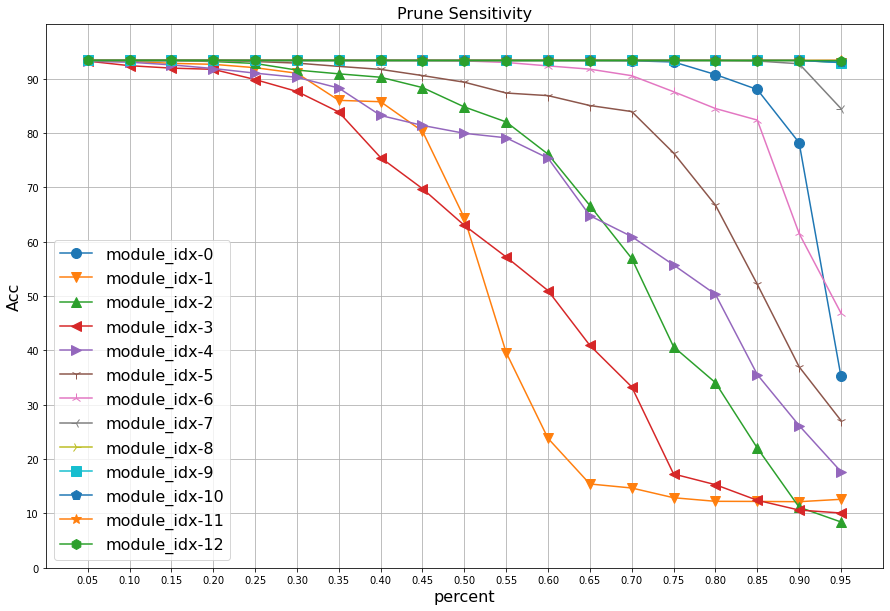

In [74]:
    import matplotlib.pyplot as plt
    from copy import deepcopy
    
    marker_list = [ 'o',       # circle marker  
                    'v',       # triangle_down marker  
                    '^',       # triangle_up marker  
                    '<',       # triangle_left marker  
                    '>',       # triangle_right marker  
                    '1',       # tri_down marker  
                    '2',       # tri_up marker  
                    '3',       # tri_left marker  
                    '4',       # tri_right marker  
                    's',       # square marker  
                    'p',       # pentagon marker  
                    '*',       # star marker  
                    'h',       # hexagon1 marker  
                    'H',       # hexagon2 marker  
                    '+',       # plus marker  
                    'x',       # x marker  
                    'D',       # diamond marker  
                    'd',       # thin_diamond marker  
                    '|',       # vline marker  
                    '_',        # hline marker 
                    '.',       # point marker
                    ','       # pixel marker
                  ]
    
    x = percent_list
    
    figure, ax = plt.subplots(figsize=(15,10))

    plt.xlim(0.,1.) # 设置x轴的刻度
    plt.ylim(0.,100.) # 设置y轴的刻度
    plt.xticks(x) # x轴上显示哪些文字
    plt.yticks([x for x in range(0,100,10)]) # y轴上显示哪些文字
    
    y_list = []
    y = []
    for i,s in enumerate(sen):
        y.append(s[3])
        
        if i%(len(x)) == (len(x)-1):
            y_list.append(deepcopy(y))
            y.clear()
    
    for i,y in enumerate(y_list):
        label = "module_idx-" + str(i)
        marker = marker_list[i%len(y_list)]
        
        # label表示将要显示在图例中的文字
        # marker表示折现上每个点的图形形状
        # ms表示每个点的大小
        plt.plot(x,y,label=label,marker=marker,ms=10) 

    plt.tick_params(labelsize=10) # 坐标轴的字体大小
    
    font1 = { 'family' : 'Times New Roman',
            'weight' : 'normal',
            'size'   : 16,
        }
    plt.legend(prop=font1) # 设置图例
    
    plt.xlabel('percent', font1) # X轴标题
    plt.ylabel('Acc', font1) # Y轴标题
    plt.title('Prune Sensitivity', font1) # 图标题
    
    plt.grid() # 图中显示表格
        
#     img_file=os.path.join(opt.saved_dir, "%s_sensitivity.svg"%opt.model_name)
#     plt.savefig(fname=img_file,format="svg")
    plt.show()